<a href="https://colab.research.google.com/github/sultanbst123/Zindi_Africa-Coral-Classification-Challenge/blob/main/Coral_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coral Classification

## Library & File

In [ ]:
!nvidia-smi

Sun Jan  9 12:23:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
pip install -U keras-efficientnet-v2

In [ ]:
import pandas as pd
import numpy as np
import gdown
import random 
import os

from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns 

#DL library
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_efficientnet_v2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Coral Classification/Train.csv")
test = pd.read_csv("/content/drive/MyDrive/Coral Classification/Test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21680 entries, 0 to 21679
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  21680 non-null  object
 1   label     21680 non-null  object
dtypes: object(2)
memory usage: 338.9+ KB


In [ ]:
# ambil gambar dari gdrive, lalu extract ke file baru 

with ZipFile("/content/drive/MyDrive/Coral Classification/coral_image.zip", "r") as zipobj:
     zipobj.extractall("coral_img")

In [ ]:

# buat file baru yang berisi gambar coral

train["path"] = "/content/coral_img/coral_image/" + train["Image_ID"] + ".jpg"
test["path"] = "/content/coral_img/coral_image/" + test["Image_ID"] + ".jpg"

In [ ]:
train.head()

,Image_ID,label,path
0,ImageID_001G9EFI,Other,/content/coral_img/coral_image/ImageID_001G9EF...
1,ImageID_0026LXMN,Hard Coral,/content/coral_img/coral_image/ImageID_0026LXM...
2,ImageID_004J6Y6A,Hard Coral,/content/coral_img/coral_image/ImageID_004J6Y6...
3,ImageID_0056CP11,Hard Coral,/content/coral_img/coral_image/ImageID_0056CP1...
4,ImageID_00AV0G9B,Other,/content/coral_img/coral_image/ImageID_00AV0G9...


In [ ]:
test.head()

,Image_ID,path
0,ImageID_001KGM1C,/content/coral_img/coral_image/ImageID_001KGM1...
1,ImageID_0048JTR3,/content/coral_img/coral_image/ImageID_0048JTR...
2,ImageID_00491SIG,/content/coral_img/coral_image/ImageID_00491SI...
3,ImageID_004B1V2U,/content/coral_img/coral_image/ImageID_004B1V2...
4,ImageID_00C0Q21B,/content/coral_img/coral_image/ImageID_00C0Q21...


## Explore Dataset

In [ ]:
# target

,label
Algae,11530
Hard Coral,6067
Other,1571
Soft Coral,1553
Other Invertebrates,959


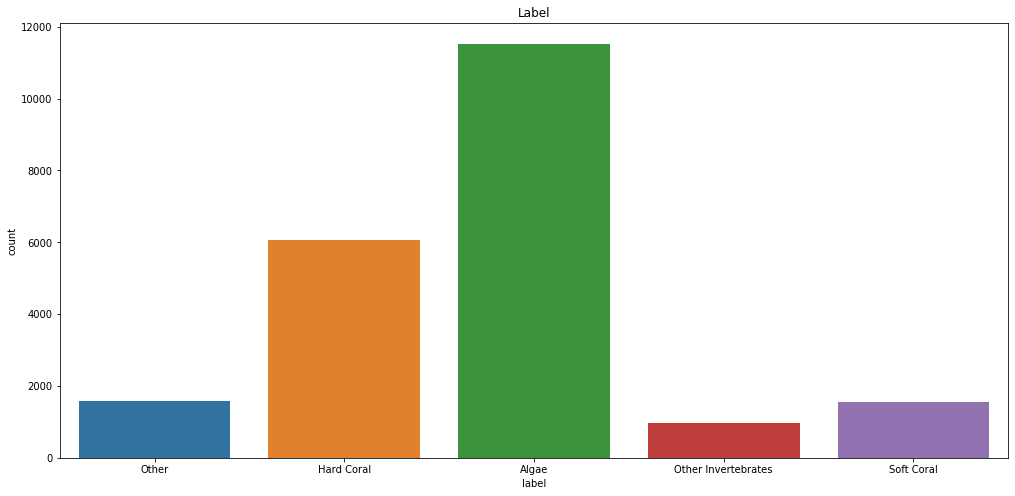

In [ ]:
plt.figure(figsize=(17, 8)) 
sns.countplot(train.label)
plt.title("Label")

train.label.value_counts().to_frame()

In [ ]:
#image

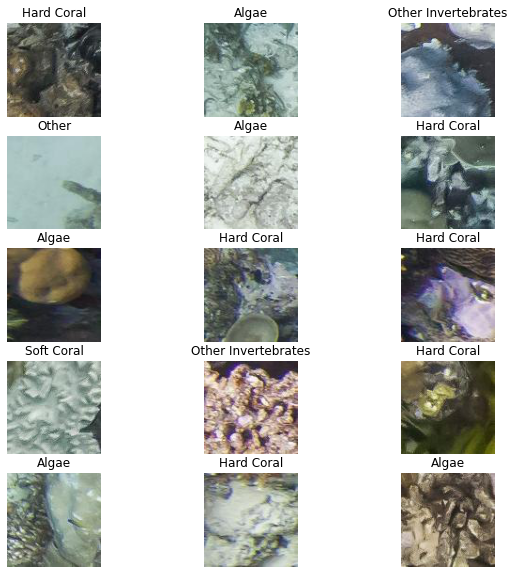

In [ ]:
# random image
random_img = np.random.choice(len(train), 15)

plt.figure(figsize=(10, 10))
for i in range(15): 
    plt.subplot(5, 3, i+1)
    img = random_img[i]
    my_img = plt.imread(train.path[img]) 
    plt.imshow(my_img) 
    plt.title(train.label[img])
    plt.axis("off")
  
plt.show()

## Image pre processing & split

In [ ]:
# split pakai image data generator dataframe

In [ ]:

# ubah ke dari nama label ke diskrit, untuk mengambil nilai asli nya 
LC = LabelEncoder() 
train["new_label"] = LC.fit_transform(train.label)

In [ ]:
BATCH_SIZE = 32 
AUTO = tf.data.AUTOTUNE
IMG_SIZE = 224 # resize imahe

In [ ]:
x = train.path
y = tf.keras.utils.to_categorical(train.new_label) # ohe label
new_test = test.path

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.05, random_state=42)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((20596,), (1084,), (20596, 5), (1084, 5))

In [ ]:

# image test
@tf.function
def get_image(path):
    """Function loads image from a file and preprocesses it.
    :param path: Path to image file
    :return: Tensor with preprocessed image
    """
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    
    ## Resizing image
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE), dtype=tf.int32)

    return image

# image train & validation
@tf.function
def process_dataset(path, label):

    """Function returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    return get_image(path), label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.map(process_dataset, num_parallel_calls=AUTO).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_ds = val_ds.map(process_dataset, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((new_test))
test_ds = test_ds.map(get_image, num_parallel_calls=AUTO).batch(BATCH_SIZE)

train_ds, val_ds, test_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.int32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.int32, tf.float32)>,
 <BatchDataset shapes: (None, 224, 224, 3), types: tf.int32>)

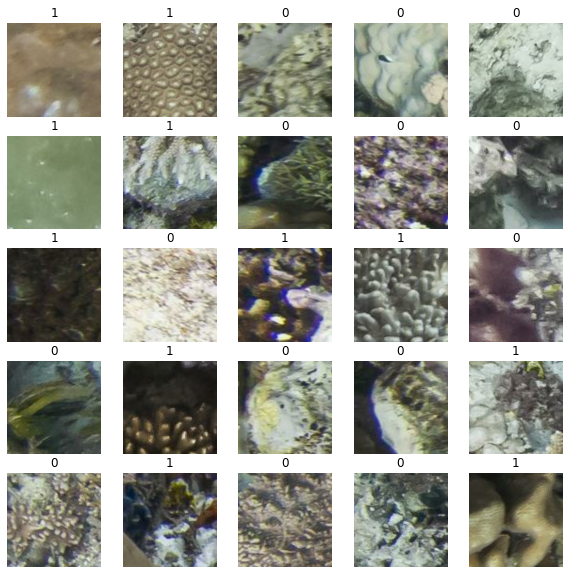

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(np.argmax(label_batch[n].numpy()))
    plt.axis("off")

## Define Hyper parameters

In [ ]:
# Hyperparamters for fit 

EPOCHS = 15
INIT_LR = 1e-4 
MAX_LR = 1e-2
Wd = 1e-5

#define learning rate scheduler
steps_per_epoch =  len(x_train) // BATCH_SIZE

clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= 2 * steps_per_epoch
)

#define optimizers 
ADAM = tf.keras.optimizers.Adam(learning_rate=clr)
SGD = tf.keras.optimizers.SGD(learning_rate=clr, momentum=0.9)
 
ADABELIEF = tfa.optimizers.AdaBelief(learning_rate = clr, weight_decay = Wd)#recified == True default,  warmup 0.1
ADAMW = tfa.optimizers.AdamW(learning_rate = clr, weight_decay = Wd)

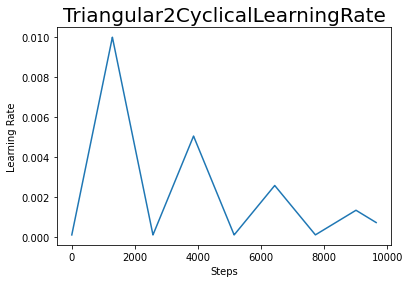

In [ ]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Triangular2CyclicalLearningRate", size=20)
plt.show()

## EfficientNetV2B1

In [ ]:

import keras_efficientnet_v2

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Resizing(240,240), # resize image 
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ], 
    name="data_augmentation",
)

In [ ]:

# /// get model ////
input = layers.Input(shape=(224, 224, 3))

# augmentation  
x = data_augmentation(input)

# resnetrs model
Eff = keras_efficientnet_v2.EfficientNetV2B1(input_shape=(240,240,3),num_classes = 0,pretrained="imagenet21k",include_preprocessing = True)(x)

# add fc      
x1 = layers.GlobalAveragePooling2D()(Eff)
x1 = layers.Dropout(0.1)(x1)
x1 = layers.Dense(128, activation = "selu", kernel_initializer = "lecun_normal")(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(64, activation = "selu", kernel_initializer = "lecun_normal")(x1) 
x1 = layers.Dropout(0.2)(x1)
output = layers.Dense(5, activation="softmax")(x1)

model = tf.keras.Model(inputs=input, outputs=output, name = "EfficientNetV2") 
   

# freeze EfficientNetV2B1
for layer in model.layers[2:3]:
    layer.trainable = False


#compile model 
model.compile(optimizer = ADABELIEF, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), # tambahkan label_smoothing karena overfit 
              metrics = ["acc"])

model.summary()

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b1-21k.h5
Model: "EfficientNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 240, 240, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B1 (Functiona  (None, 8, 8, 1280)       6931124   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (N

In [ ]:
cp_path = f"best_cp.hdf5"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/15
644/644 [==============================] - 154s 221ms/step - loss: 1.3995 - acc: 0.5170 - val_loss: 1.1570 - val_acc: 0.5932
Epoch 2/15
644/644 [==============================] - 139s 214ms/step - loss: 1.1942 - acc: 0.5877 - val_loss: 1.1334 - val_acc: 0.6190
Epoch 3/15
644/644 [==============================] - 139s 214ms/step - loss: 1.1955 - acc: 0.5883 - val_loss: 1.1352 - val_acc: 0.6107
Epoch 4/15
644/644 [==============================] - 139s 214ms/step - loss: 1.1344 - acc: 0.6137 - val_loss: 1.0892 - val_acc: 0.6338
Epoch 5/15
644/644 [==============================] - 139s 213ms/step - loss: 1.1118 - acc: 0.6268 - val_loss: 1.1268 - val_acc: 0.6375
Epoch 6/15
644/644 [==============================] - 139s 214ms/step - loss: 1.1630 - acc: 0.6001 - val_loss: 1.1605 - val_acc: 0.6006
Epoch 7/15
644/644 [==============================] - 139s 214ms/step - loss: 1.1703 - acc: 0.5971 - val_loss: 1.1570 - val_acc: 0.5904
Epoch 8/15
644/644 [============================

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"loss : {loss}") 
print(f"val accuracy : {round(accuracy * 100, 2)}%")

34/34 [==============================] - 6s 186ms/step - loss: 1.0788 - acc: 0.6421
loss : 1.078768253326416
val accuracy : 64.21%


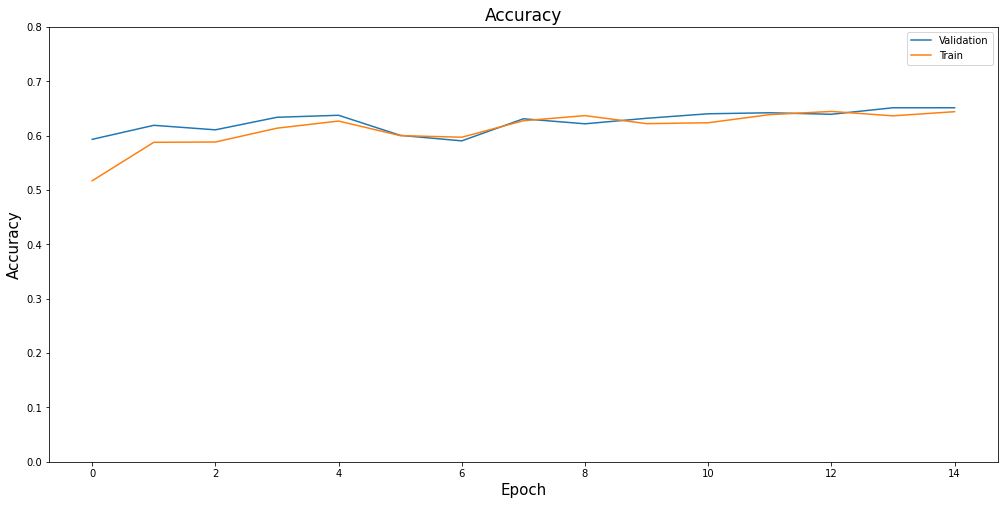

In [ ]:
#plot accuracy

plt.figure(figsize=(17, 8)) 

plt.plot(history.history["val_acc"],label="Validation")
plt.plot(history.history["acc"],label="Train")
plt.xlabel("Epoch", size=15) 
plt.ylabel("Accuracy", size=15)
plt.title("Accuracy", size=17)
plt.ylim([0,0.8]) 
plt.legend() 
plt.show()

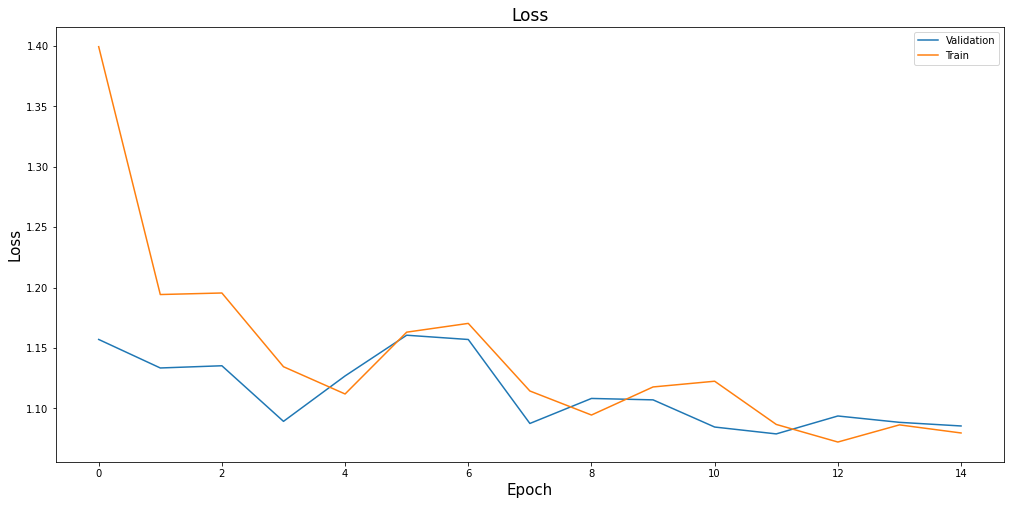

In [ ]:

#plot loss 

plt.figure(figsize=(17, 8)) 

plt.plot(history.history["val_loss"],label="Validation")
plt.plot(history.history["loss"],label="Train")
plt.xlabel("Epoch", size=15) 
plt.ylabel("Loss", size=15)
plt.title("Loss", size=17)
plt.legend() 
plt.show()

In [ ]:

# predict validation data 

y_true = model.predict(val_ds)

In [ ]:
classification_report(LC.inverse_transform(np.argmax(y_val,axis=1)),LC.inverse_transform(np.argmax(y_true,axis=1)))

'                     precision    recall  f1-score   support\n\n              Algae       0.63      0.88      0.73       574\n         Hard Coral       0.65      0.47      0.55       309\n              Other       0.74      0.35      0.47        75\nOther Invertebrates       0.70      0.30      0.42        53\n         Soft Coral       0.83      0.07      0.13        73\n\n           accuracy                           0.64      1084\n          macro avg       0.71      0.41      0.46      1084\n       weighted avg       0.66      0.64      0.61      1084\n'

Text(0.5, 1.0, 'Confusion Matrix')

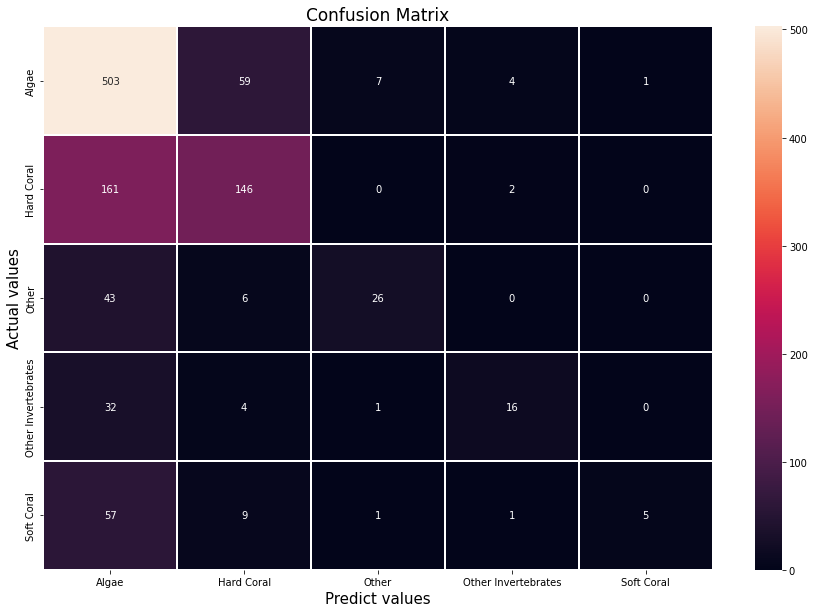

In [ ]:

# actual vs predict

cf_matrix = pd.crosstab(LC.inverse_transform(np.argmax(y_val,axis=1)),LC.inverse_transform(np.argmax(y_true,axis=1)))

plt.figure(figsize=(15,10)) 
sns.heatmap(cf_matrix, annot= True, linewidth=1, fmt = "d")
plt.xlabel("Predict values",size=15) 
plt.ylabel("Actual values",size=15)
plt.title("Confusion Matrix", size=17)

## make a submission

In [ ]:
test_ds

<BatchDataset shapes: (None, 224, 224, 3), types: tf.int32>

In [ ]:
test_label = model.predict(test_ds)

In [ ]:
Sub = pd.read_csv("/content/drive/MyDrive/Coral Classification/SampleSubmission.csv")

In [ ]:
Sub

,Image_ID,label
0,ImageID_001KGM1C,NaN
1,ImageID_0048JTR3,NaN
2,ImageID_00491SIG,NaN
3,ImageID_004B1V2U,NaN
4,ImageID_00C0Q21B,NaN
...,...,...
11958,ImageID_ZZP1Y9Z1,NaN
11959,ImageID_ZZPHNP5L,NaN
11960,ImageID_ZZUIMD0P,NaN
11961,ImageID_ZZUXL8E9,NaN


In [ ]:
Sub["label"] = LC.inverse_transform(np.argmax(test_label, axis=1))

In [ ]:
Sub.sample(10)

,Image_ID,label
7388,ImageID_MDILGGG6,Hard Coral
8679,ImageID_Q68075NP,Algae
4714,ImageID_EF9T9L85,Algae
5038,ImageID_FDGJVSRM,Soft Coral
6391,ImageID_JDJG7B2H,Algae
11535,ImageID_YROD5BIE,Algae
10095,ImageID_UEIASAUO,Algae
11867,ImageID_ZP99PGJG,Hard Coral
3181,ImageID_9TDLCV4O,Algae
10060,ImageID_UA4HITED,Algae


In [ ]:
Sub.to_csv("submission.csv", index=False)